# ** Code to download and plot reservoir storage-level data from USGS ** 
## ** Importing libraries **

In [4]:
import mechanicalsoup # Not needed for this code, but I use it for 
                      # interacting with other websites.  
import pandas as pd
import urllib.parse
import urllib.request
import matplotlib.pyplot as plt
import numpy as np

## ** Accessing data from USGS **
** usgscode, usgsname, prop2, ** and ** prop1 ** are obtained from the 
USGS page for the appropriate reservoir. For example, the page for Lake
Havasu is [https://waterdata.usgs.gov/nwis/uv/?site_no=09427500&PARAmeter_cd=00065,72020,00054](available here). From the page url as well as the page contents, you can see that the properties of interest
are '00065' and '00054'. 00054 refers to ** Reservoir Storage ** and ** 00065 ** to Gage Level. I do not know what '72020' refers to. For many other reservoirs, the appropriate properties are ** prop2 = '00054'
prop1 = '62614'**. 62614 refers to a slightly different form of gage level.

The url from which the data can be downloaded is constructed as:
url = 'https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_'+prop1+ '=on' + \
        '&cb_' + prop2 + '=on&format=html&site_no=' + usgscode + \
        '&period=&begin_date='+begin_date+'&end_date='+end_date
        
pandas is used to read the tables in the webpage for Lake Havasu. I store that data in a csv file with the naming convention ** usgsname.csv **. 

In [11]:
begin_date = '2017-08-31'
end_date = '2020-08-31'

usgscode = '10337000'
usgsname = 'lakehavasu'
prop2 = '00054'
prop1 = '00065'

usgscode = '11020600'
usgsname = 'elcapitan'
prop2 = '00054'
prop1 = '62614'

usgscode = '11451290'
usgsname = 'indianvalley'
prop2 = '00054'
prop1 = '62614'

usgscode = '11022100'
usgsname = 'sanvicentereservoir'
prop2 = '00054'
prop1 = '62614'

usgscode = '07226800'
usgsname = 'utereservoir'
prop2 = '00054'
prop1 = '62615'

'''
# This part of the code is useful but does not work properly enough.
# The intention of this method is to determine the property codes for
# level and storage for the particlar reservoir/lake. It turns out 
# there are many such codes which correspond to the same physical
# quantity. The URL of interest needs these property codes. 
# Until this code is fixed, a better way might be to identify the codes
# manually and include them, as I have done for San Vicente Reservoir.

urlsite = "https://waterdata.usgs.gov/nwis/uv/?site_no=" + usgscode
req = urllib.request.Request(urlsite)

with urllib.request.urlopen(req) as response:
    init_page = response.read()

numParameters = len(pd.read_html(init_page)[-1]['Available Parameters'])
prop1 = pd.read_html(init_page)[0]['Available Parameters'][numParameters-2].split(' ')[0]
prop2 = pd.read_html(init_page)[0]['Available Parameters'][numParameters-1].split(' ')[0]


'''

url = 'https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_'+prop1+ '=on' + \
        '&cb_' + prop2 + '=on&format=html&site_no=' + usgscode + \
        '&period=&begin_date='+begin_date+'&end_date='+end_date
#+'begin_date='+begin_date+'&end_date='+end_date

req = urllib.request.Request(url)

with urllib.request.urlopen(req) as response:
    the_page = response.read()

pdDF = pd.read_html(the_page, skiprows=0, header = 0)
numtables = len(pdDF)
lentables = [len(pdDF[n]) 
            for n in range(numtables)]
tabindex = np.where(np.array(lentables) == max(lentables))[0][0]

    
htmldf = pd.read_html(the_page, skiprows=0, header = 0)[tabindex]
htmldf['Date'] = htmldf['Date / Time'].str.split(' ', expand=True)[0]
htmldf.columns = ['Date / Time', 'Reservoir storage (acre-ft)', 'Gage height (feet)', 'Date']

htmldf['Gage height (feet)'] = htmldf['Gage height (feet)'].str.replace(pat=',', repl='')
htmldf['Reservoir storage (acre-ft)'] = htmldf['Reservoir storage (acre-ft)'].str.strip('AP A e').str.replace(',','').astype('float')
htmldf['Gage height (feet)'] = htmldf['Gage height (feet)'].str.strip('AP A e').astype('float')
#htmldf.head()

CSVfilename = usgsname + '.csv'
try:
    open(CSVfilename)
except FileNotFoundError:
    open(CSVfilename, 'w')
    f = open(CSVfilename, 'w')
    htmldf.to_csv(f, header=htmldf.columns)
    
with open(CSVfilename, 'a') as f:
    htmldf.to_csv(f, header=False)

## ** Functions for plotting data **

In [47]:
def plottingUSGSReservoirData(filename, xloc, yloc, axobj):
    '''
    function to plot daily gage level and storage, labeled by year.
    
    filename: string, path pointing to file containing data
    xloc: string, column name for x-axis. 'Reservoir storage (acre-ft)' is 
            what is to be used most often, especially given the code in 
            the previous cell.
    yloc: string, column name for y-axis. 'Gage height (feet)' is 
            what is to be used most often, especially given the code in 
            the previous cell.
    axobj: axes object on which the data will be plotted
    '''
    
    df_full = pd.read_csv(filename)
    
    #df_full = df_full.fillna('-')
    grpbyyr = df_full.groupby(df_full['Date'].str.split('/', expand=True)[2])
    
    for group in grpbyyr.groups:
        year = group
        df = grpbyyr.get_group(group).dropna()
        
        axobj.plot(df[xloc].astype(float), 
                   df[yloc].astype(float), 'o', label=str(year))
        
        axobj.set_xlabel(xloc, fontsize=16)
        axobj.set_ylabel(yloc, fontsize=16)
        
    plt.setp(axobj.get_xticklabels(), fontsize=16)
    plt.setp(axobj.get_yticklabels(), fontsize=16)
        
    axobj.legend(loc='lower right')
    axobj.set_title(filename.split('.')[0], fontsize=18)


def plottingUSGSReservoirMedianYearlyData(filename, y1loc, y2loc, axobj):
    '''
    function to plot annual median values for gage level and storage 
    versus year.
    
    filename: string, path pointing to file containing data
    y1loc: string, column name for y1-axis. 'Gage height (feet)' is 
            what is to be used most often, especially given the code in 
            the previous cells
    y2loc: string, column name for y2-axis. 'Reservoir storage (acre-ft)' 
            is what is to be used most often, especially given the code 
            in the previous cells
    axobj: axes object on which the data will be plotted
    '''
    
    df_full = pd.read_csv(filename)
    yearlyMedianData = pd.DataFrame()
    #df_full = df_full.fillna('-')
    grpbyyr = df_full.groupby(df_full['Date'].str.split('/', expand=True)[2])
    
    for group in grpbyyr.groups:
        year = group
        df = grpbyyr.get_group(group).dropna()
        df['Year'] = int(year)
        yearlyMedianData = yearlyMedianData.append(pd.DataFrame(df.median()).T)
        #print(yearlyMedianData)
        
    axobj.plot(yearlyMedianData['Year'], 
               yearlyMedianData[y1loc], 'o', c = 'b')
    axobj.set_xlim([yearlyMedianData['Year'].min()-1, 
                    yearlyMedianData['Year'].max()+1 ])
    axobj.set_xlabel('Year', fontsize=16)
    axobj.set_ylabel(y1loc, fontsize=16)
    
    plt.setp(axobj.get_xticklabels(), fontsize=16)
    plt.setp(axobj.get_yticklabels(), fontsize=16)
    
    axobjtwin = axobj.twinx()
    axobjtwin.plot(yearlyMedianData['Year'], 
                   yearlyMedianData[y2loc], 'd', c='r')
    axobjtwin.set_ylabel(y2loc, fontsize=16)
    
    plt.setp(axobjtwin.get_xticklabels(), fontsize=16)
    plt.setp(axobjtwin.get_yticklabels(), fontsize=16)

### ** Example of plotting data downloaded from USGS reservoir data **

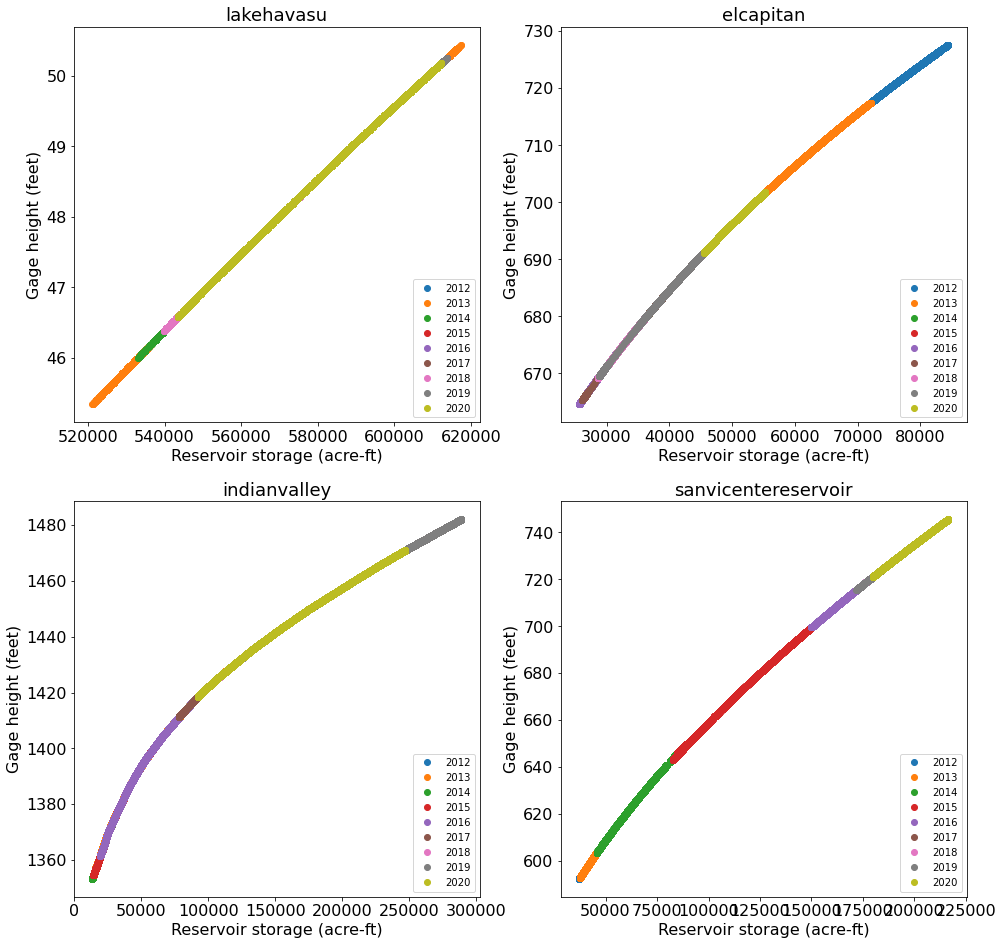

In [41]:
g, ((axa,axb),(axc,axd)) = plt.subplots(2,2, figsize=(16,16))
plottingUSGSReservoirData('lakehavasu.csv', 'Reservoir storage (acre-ft)', 'Gage height (feet)', axa)
plottingUSGSReservoirData('elcapitan.csv', 'Reservoir storage (acre-ft)', 'Gage height (feet)', axb)
plottingUSGSReservoirData('indianvalley.csv', 'Reservoir storage (acre-ft)', 'Gage height (feet)', axc)
plottingUSGSReservoirData('sanvicentereservoir.csv', 'Reservoir storage (acre-ft)', 'Gage height (feet)', axd)

### ** Example of plotting yearly median data **

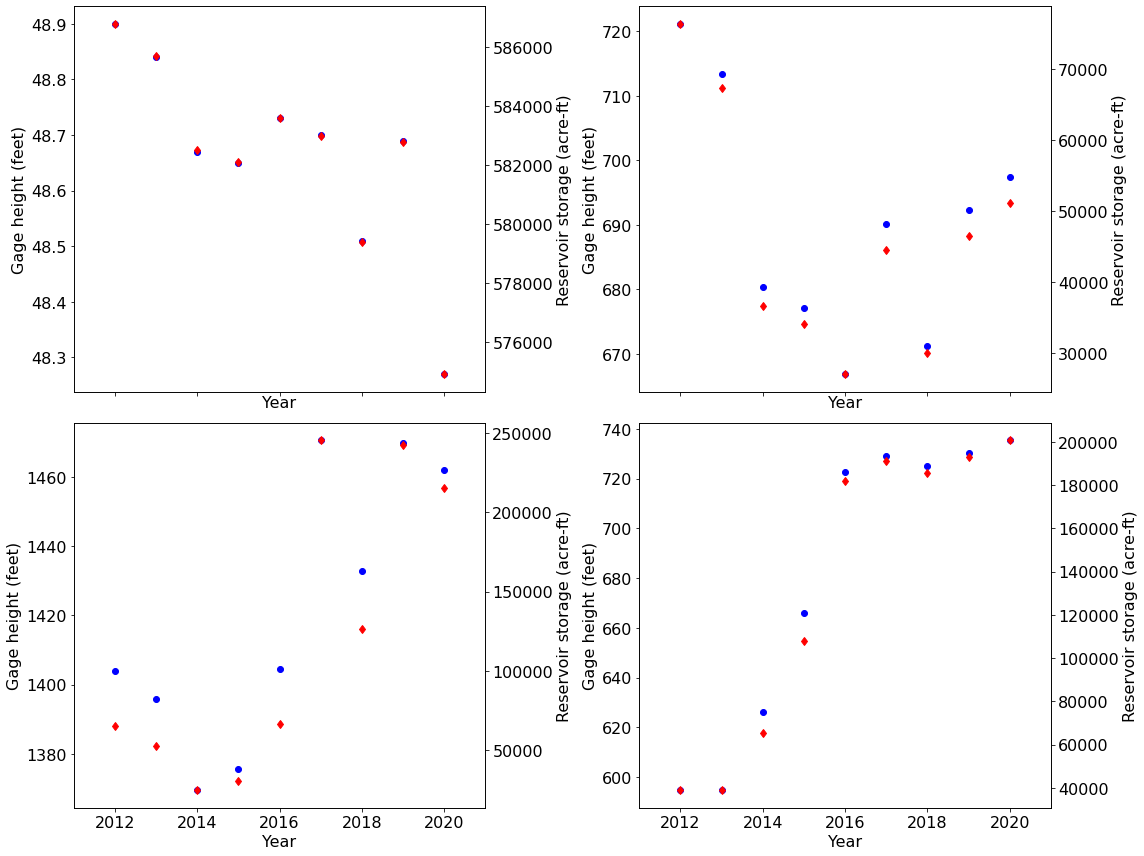

In [46]:
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, sharex=True, figsize=(16,12))
plottingUSGSReservoirMedianYearlyData('lakehavasu.csv', 
                                      'Gage height (feet)',
                                     'Reservoir storage (acre-ft)', ax1)
plottingUSGSReservoirMedianYearlyData('elcapitan.csv', 
                                      'Gage height (feet)',
                                     'Reservoir storage (acre-ft)', ax2)
plottingUSGSReservoirMedianYearlyData('indianvalley.csv', 
                                      'Gage height (feet)',
                                     'Reservoir storage (acre-ft)', ax3)
plottingUSGSReservoirMedianYearlyData('sanvicentereservoir.csv', 
                                      'Gage height (feet)',
                                     'Reservoir storage (acre-ft)', ax4)

plt.tight_layout()